In [ ]:
import rospy
import cv2
import tf2_ros
import tf2_geometry_msgs
import numpy as np
import matplotlib.pyplot as plt
from nav_msgs.msg import Odometry
from nav_msgs.msg import Path
from nav_msgs.msg import OccupancyGrid
from geometry_msgs.msg import Twist

In [ ]:
res_remap = 0.01
itra = 9
map_x = 0.0
map_y = 0.0
map_org_x = 0.0
map_org_y = 0.0
map_res = 0.0
mapdata = None
orgmapdata = None
map_rec = False
globalpath = []
current_odom = 0

In [ ]:
def get_local_region(x,y): # in grid
    roi = mapdata[y-200:y+200,x-200:x+200]
    return roi

In [ ]:
def get_position_in_grid(odom):
    tfbuffer = tf2_ros.Buffer()
    listener = tf2_ros.TransformListener(tfbuffer)
    t_a_b = tfbuffer.lookup_transform('map', odom.header.frame_id, rospy.Time(0), rospy.Duration(10.0))
    odom.pose = tf2_geometry_msgs.do_transform_pose(odom.pose, t_a_b)
    resp_odom = meters2grid((odom.pose.pose.position.x, odom.pose.pose.position.y))
    return resp_odom

In [5]:
def meters2grid(pose_m):
    if np.isscalar(pose_m):
        print("meters2grid scalar version used")
        pose_on_grid = int( pose_m / map_res + map_org_x )
    else:
        pose_on_grid = np.array((np.array(pose_m) - [map_org_x, -map_org_y])/ map_res, dtype=int)
    pose_on_grid[1] = -map_org_y - pose_on_grid[1] 
    return pose_on_grid

In [6]:
def grid2meters(pose_grid):
    if np.isscalar(pose_grid):
        pose_meters = (pose_grid * map_res + map_org_x)
        print("grid2meters scalar version used")
    else:
        pose_meters = ( np.array(pose_grid)* map_res + np.array([map_org_x,map_org_y]) )
    pose_meters[:,1] = -pose_meters[:,1]
    return pose_meters

In [7]:
def map_callback(data):
    global mapdata
    global orgmapdata
    global map_x
    global map_y
    global map_org_x
    global map_org_y
    global map_res
    global res_remap
    global map_rec
    
    map_x = data.info.width
    map_y = data.info.height
    map_org_x = data.info.origin.position.x
    map_org_y = data.info.origin.position.y
    map_res = data.info.resolution
    
    mapdata = np.asarray(data.data).reshape(data.info.height,data.info.width).astype(np.uint8)
    mapdata = np.flip(mapdata,0)
    orgmapdata = mapdata
    kernel = np.ones((int(res_remap*map_y),int(res_remap*map_x)),np.uint8)
    mapdata = cv2.dilate(mapdata,kernel,iterations = itra)
    mapdata = np.invert(mapdata)
    mapdata = np.where(mapdata<250,0,mapdata)
    map_rec = True
    
    plt.grid(True)
    plt.imshow(mapdata)
    plt.show() 

def path_callback(data):
    global mapdata
    global globalpath
    global orgmapdata
    globalpath = []
    x = []
    y = []
    for i in range(len(data.poses)):
        ans = meters2grid((data.poses[i].pose.position.x,
                                       data.poses[i].pose.position.y))
        x.append(ans[0])
        y.append(ans[1])
    globalpath.append(x)
    globalpath.append(y)
    globalpath = np.flip(globalpath,1)
    plt.imshow(mapdata+orgmapdata)
    plt.grid(True)
    plt.plot(globalpath[0],globalpath[1],"bo")
    plt.show()

def odom_callback(data):
    global current_odom
    global map_rec
    if (map_rec):
        current_odom = data
#     print("got")

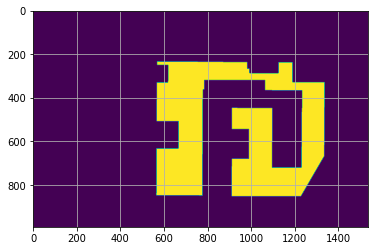

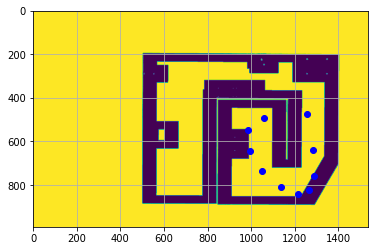

In [8]:
rospy.init_node('LocalPlanner', anonymous=True)
rospy.Subscriber("/map", OccupancyGrid, map_callback)
rospy.Subscriber("/path", Path, path_callback)
rospy.Subscriber("/jackal0/odometry/local_filtered", Odometry, odom_callback)
path_pub = rospy.Publisher('/jackal0/cmd_vel', Twist, queue_size=10)

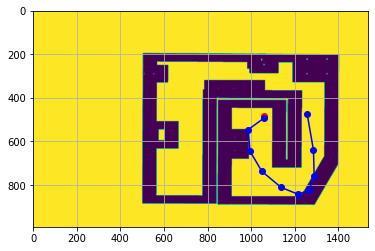

In [9]:
plt.imshow(mapdata+orgmapdata)
rpose = get_position_in_grid(current_odom)
plt.plot(rpose[0],rpose[1],"ro")
plt.grid(True)
plt.plot(globalpath[0],globalpath[1],"-bo")
plt.show()

(100, 100)


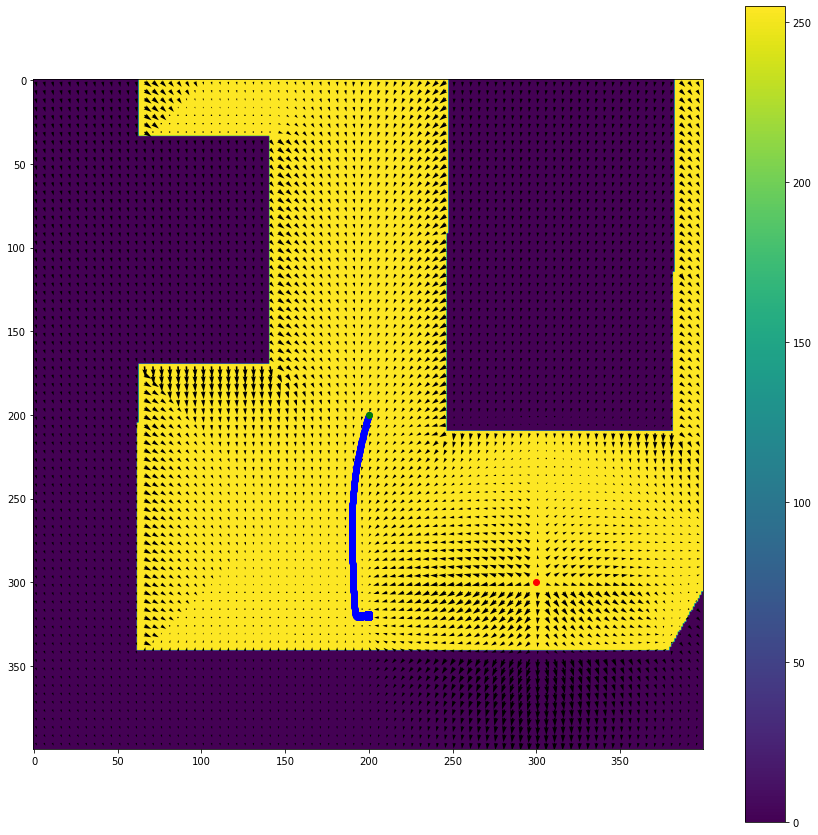

In [1404]:
from scipy.ndimage.morphology import distance_transform_edt as bwdist
class local_region:
    def __init__(self, origin_x, origin_y, width=200):
        self.org_x = origin_x
        self.org_y = origin_y
        self.data = None
        self.force = None
        self.attractive = None
        self.repulsive = None
        self.data = mapdata[origin_y-width:origin_y+width,origin_x-width:origin_x+width]
        
    def set_map_data(self,data):
        self.data = data
        
    def get_map_data(self):
        return self.data
    
    def get_origin(self):
        return [self.org_x,self.org_y]
    
    def compute_map_repulsive_force(self,influence_radius = 7, repulsive_coef = 100):
        img = np.zeros((400, 400), np.uint8)
        bdist = bwdist(self.data==255)
        bdist2 = (bdist/100.) + 1
        repulsive = repulsive_coef*((1./bdist2 - 1./influence_radius)**2)
        repulsive [bdist2 > influence_radius] = 0
        self.repulsive = repulsive
        return repulsive
    
    def compute_attractive_force(self, goal = [50,50],attractive_coef = 1./100):
        [x, y] = np.meshgrid(np.arange(self.data.shape[1]), np.arange(self.data.shape[0]))
        attractive = attractive_coef * ( (x - goal[0])**2 + (y - goal[1])**2 )
        self.attractive = attractive
        return attractive
    
    def compute_pallet_force(self, goal = [50,50], repulsive_coef = 1./10 ):
        [px, py] = np.meshgrid(np.arange(self.data.shape[0]/4), np.arange(self.data.shape[1]/4))
        attractive =  -repulsive_coef * ((px - self.data.shape[0]/8)**2 + (py - self.data.shape[1]/8)**2 )
        [x, y] = np.meshgrid(np.ones(self.data.shape[0]), np.ones(self.data.shape[1]))
        x = x + np.min(attractive)
        y = y + np.min(attractive)
        whole = x + y
        print(attractive.shape)
        whole[int(goal[0]-self.data.shape[0]/8):int(goal[0]+self.data.shape[0]/8),
              int(goal[1]-self.data.shape[1]/8):int(goal[1]+self.data.shape[1]/8)] = attractive
        whole = cv2.blur(whole,(100,100))
        return whole,attractive
    
    def compute_forces(self,goal = [50,50],pallet_goal=[100,100], influence_radius = 7, repulsive_coef = 100, attractive_coef = 1./100):
        repulsive = self.compute_map_repulsive_force(influence_radius,repulsive_coef)
        attractive = self.compute_attractive_force(goal,attractive_coef)
        pallet_repulsive,po =  self.compute_pallet_force(pallet_goal,repulsive_coef=.25)
        self.force =  pallet_repulsive + attractive + repulsive
        return self.force 
    

    def visualize_forces (self):
        skip = 5
        [x_m, y_m] = np.meshgrid(np.linspace(1, 400,400), np.linspace(1, 400,400))
        [gy, gx] = np.gradient(self.force);
        gx = -gx
        q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]
        plt.figure(figsize=(15,15))
        plt.imshow(self.data)
        plt.colorbar()
        plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])
        return plt
    
    def gradient_planner (self, start_coords):
        [gy, gx] = np.gradient(-self.force);
        route = np.array([np.array(start_coords)])
        ix = 0
        iy = 0
        max_itr = 0
        while(((ix < len(gx)-2) and (ix < len(gy)-2)) and max_itr < 1000):
            current_point = route[-1,:];
            ix = int( current_point[1] )
            iy = int( current_point[0] )
            vx = gx[ix, iy]
            vy = gy[ix, iy]
            dt = 1 / np.linalg.norm([vx, vy]);
            next_point = current_point + dt*np.array( [vx, vy] );
            route = np.vstack( [route, next_point] ); 
            max_itr = max_itr + 1 
        return route

tt = 2
a = local_region(globalpath[0][tt],globalpath[1][tt])
path_goal_pose = [200,800]
pallet_pose = [300,300]
robot_pose = [200,200]
r = a.compute_forces(goal=path_goal_pose,pallet_goal = pallet_pose,influence_radius = 2, 
                                                        repulsive_coef = 2200, 
                                                        attractive_coef = 1./100)
test = a.visualize_forces()
route = a.gradient_planner(robot_pose)
test.plot(route[:,0],route[:,1],"bo--")
test.plot(robot_pose[0],robot_pose[1],"go")
test.plot(pallet_pose[0],pallet_pose[1],"ro")
test.show()

In [1176]:
r.shape#

(400, 400)

In [1181]:
np.linspace(0, 400,400)

array([  0.        ,   1.00250627,   2.00501253,   3.0075188 ,
         4.01002506,   5.01253133,   6.01503759,   7.01754386,
         8.02005013,   9.02255639,  10.02506266,  11.02756892,
        12.03007519,  13.03258145,  14.03508772,  15.03759398,
        16.04010025,  17.04260652,  18.04511278,  19.04761905,
        20.05012531,  21.05263158,  22.05513784,  23.05764411,
        24.06015038,  25.06265664,  26.06516291,  27.06766917,
        28.07017544,  29.0726817 ,  30.07518797,  31.07769424,
        32.0802005 ,  33.08270677,  34.08521303,  35.0877193 ,
        36.09022556,  37.09273183,  38.0952381 ,  39.09774436,
        40.10025063,  41.10275689,  42.10526316,  43.10776942,
        44.11027569,  45.11278195,  46.11528822,  47.11779449,
        48.12030075,  49.12280702,  50.12531328,  51.12781955,
        52.13032581,  53.13283208,  54.13533835,  55.13784461,
        56.14035088,  57.14285714,  58.14536341,  59.14786967,
        60.15037594,  61.15288221,  62.15538847,  63.15

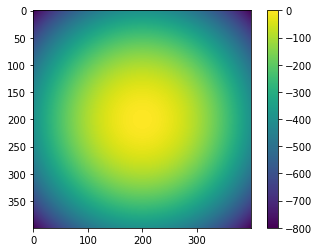

In [928]:
plt.imshow(r)
plt.colorbar()

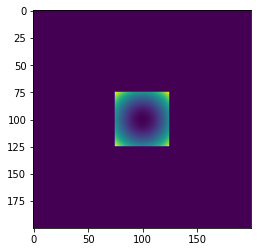

In [1193]:
[x, y] = np.meshgrid(np.arange(50), np.arange(50))
ff = ((y - 25)**2) + ((x - 25)**2)

[px, py] = np.meshgrid(np.zeros(200), np.zeros(200))
fff= px+py

fff[(int((fff.shape[0]/2)-(ff.shape[0]/2))):int(((fff.shape[0]/2)+(ff.shape[0]/2))),
    (int((fff.shape[1]/2)-(ff.shape[1]/2))):int(((fff.shape[1]/2)+(ff.shape[1]/2)))]=ff
plt.imshow(fff)

5000

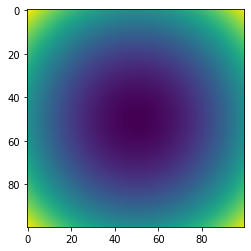

In [1210]:
[x, y] = np.meshgrid(np.arange(100), np.arange(100))
a = ((x - 50)**2) + ((y - 50)**2)
plt.imshow(a)
np.max(a)

In [1238]:
np.vstack(a[:,0]).reshape(100)

array([5000, 4901, 4804, 4709, 4616, 4525, 4436, 4349, 4264, 4181, 4100,
       4021, 3944, 3869, 3796, 3725, 3656, 3589, 3524, 3461, 3400, 3341,
       3284, 3229, 3176, 3125, 3076, 3029, 2984, 2941, 2900, 2861, 2824,
       2789, 2756, 2725, 2696, 2669, 2644, 2621, 2600, 2581, 2564, 2549,
       2536, 2525, 2516, 2509, 2504, 2501, 2500, 2501, 2504, 2509, 2516,
       2525, 2536, 2549, 2564, 2581, 2600, 2621, 2644, 2669, 2696, 2725,
       2756, 2789, 2824, 2861, 2900, 2941, 2984, 3029, 3076, 3125, 3176,
       3229, 3284, 3341, 3400, 3461, 3524, 3589, 3656, 3725, 3796, 3869,
       3944, 4021, 4100, 4181, 4264, 4349, 4436, 4525, 4616, 4709, 4804,
       4901])

In [1268]:
[tx, ty] = np.meshgrid(np.ones(300), np.ones(300))

In [1274]:
tx = tx*np.max(a)
# tx[0:100,0:100]=5
# tx[0:100,200:300]=5000
# tx[200:300,0:100]=5000
# tx[200:300,200:300]=5000
# tx[100:200,0:100] = np.vstack(a[:,0])
# tx[100:200,200:300] = np.vstack(a[:,0])
# tx[0:100,100:200] = np.vstack(a[:,0]).reshape(100)
# tx[200:300,100:200] = np.vstack(a[:,0]).reshape(100)
tx[100:200,100:200] = a

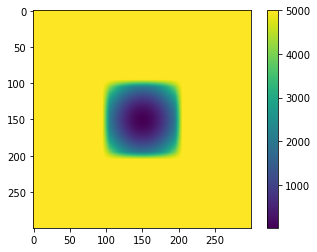

In [1281]:
plt.imshow(cv2.blur(tx,(10,10)))
plt.colorbar()

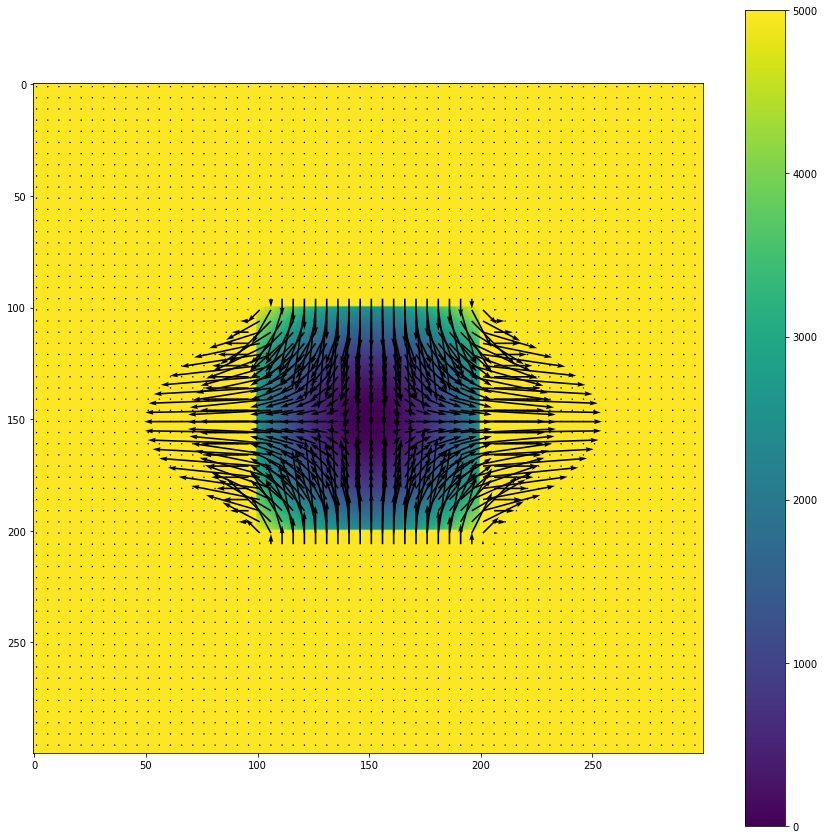

In [1284]:
skip= 5
[x_m, y_m] = np.meshgrid(np.linspace(1, 300,300), np.linspace(1, 300,300))
[gy, gx] = np.gradient(cv2.blur(tx,(10,10)));
gx = gx
q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]
plt.figure(figsize=(15,15))
plt.imshow(tx)
plt.colorbar()
plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])

In [1019]:
[px, py] = np.meshgrid(np.arange(50), np.arange(50))

In [1020]:
b = ((px - 25)**2) + ((py - 25)**2)

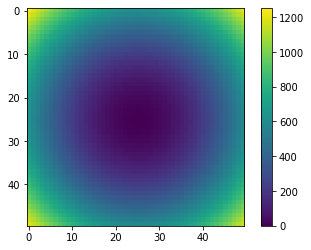

In [1021]:
plt.imshow(b)
plt.colorbar()